# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

In [2]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
import pandas
import numpy as np
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
import datetime
spark = SparkSession.builder.appName("AirBnB").getOrCreate()



# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [3]:
path_to_listings_file = "/home/suhas/Downloads/listings.csv"
dfListings = spark.read.option('header', True).option('inferSchema', True).option('multiline', True).option('escape', '"').csv(path_to_listings_file)


In [4]:
path_to_reviews_file = "/home/suhas/Downloads/reviews.csv"
dfReviews = spark.read.option('header', True).option('inferSchema', True).option('multiline', True).option('escape', '"').csv(path_to_reviews_file)

### Describe the data
List the features (schema) and sizes of the datasets.

In [4]:
dfListings.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [5]:
dfListings.count()

1330480

In [6]:
dfReviews.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



In [7]:
dfReviews.count()

32297300

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

In [5]:
dfListings = dfListings.select('id', 'city', 'neighbourhood', 'price', 'property_type', 'review_scores_value')

In [6]:
dfListings = dfListings.na.drop()

In [7]:
def fixPrice(price):
    price = price[1:].replace(',','')
    return price

In [8]:
fixPrice_udf = f.udf(fixPrice)

In [9]:
dfListings = dfListings.withColumn('price', fixPrice_udf(f.col('price')).cast("float"))

In [10]:
dfListings = dfListings.withColumn('review_scores_value', f.col('review_scores_value').cast("float"))

In [11]:
dfReviews = dfReviews.na.drop()

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.

In [15]:
dfListings.select('id', 'neighbourhood', 'city').groupBy('city').agg(f.count('id'),f.countDistinct('neighbourhood')).orderBy(f.desc('count(id)')).show()

+----------------+---------+-----------------------------+
|            city|count(id)|count(DISTINCT neighbourhood)|
+----------------+---------+-----------------------------+
|           Paris|    48068|                           63|
|  Greater London|    33210|                          149|
|          London|    25289|                          148|
|     Los Angeles|    22252|                           95|
|          Berlin|    19665|                           93|
|            Roma|    18545|                           42|
|         Toronto|    17857|                          140|
|       København|    17383|                           21|
|       Amsterdam|    16903|                           44|
|        New York|    16075|                           90|
|          Madrid|    15761|                           66|
|       Barcelona|    15491|                           68|
|        Brooklyn|    15117|                           51|
|         Beijing|    14102|                           6

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

In [18]:
dfListings.select('id', 'neighbourhood', 'city').filter(f.col('city') == 'København').agg(f.count('id'),f.countDistinct('neighbourhood')).orderBy(f.desc('count(id)')).show()

+---------+-----------------------------+
|count(id)|count(DISTINCT neighbourhood)|
+---------+-----------------------------+
|    17383|                           21|
+---------+-----------------------------+



In [20]:
dfListingsCopenhagen = dfListings.filter(f.col('city') == 'København')

In [21]:
dfListingsCopenhagen.select('neighbourhood').distinct().rdd.map(lambda r: r[0]).collect()

['Indre By',
 'Teglholmen',
 'Amager Øst',
 'Holmen',
 'Kødbyen',
 'Amager',
 'Valby',
 'Sluseholmen',
 'Østerbro',
 'Amagerbro',
 'Brønshøj',
 'Nørrebro',
 'København NV',
 'Nyboder',
 'Frederiksberg',
 'Vesterbro',
 'Islands Brygge',
 'Christiania',
 'Amager Vest',
 'Christianshavn',
 'Vanløse']

In [23]:
dfListingsCopenhagenPropertyTypeCount = dfListingsCopenhagen.groupBy("property_type").agg(f.count("id"))

In [24]:
x = [row["property_type"] for row in dfListingsCopenhagenPropertyTypeCount.collect()]

In [25]:
x

['Apartment',
 'Townhouse',
 'Guest suite',
 'Hut',
 'Casa particular (Cuba)',
 'Camper/RV',
 'Boutique hotel',
 'Loft',
 'Guesthouse',
 'Hostel',
 'Villa',
 'Other',
 'Serviced apartment',
 'Hotel',
 'Cottage',
 'Condominium',
 'House',
 'Island',
 'Tent',
 'Tiny house',
 'Boat',
 'Houseboat',
 'Bungalow',
 'Bed and breakfast',
 'Cabin']

In [26]:
y = [row["count(id)"] for row in dfListingsCopenhagenPropertyTypeCount.collect()]

In [27]:
y

[14752,
 355,
 15,
 2,
 1,
 2,
 4,
 153,
 12,
 19,
 80,
 9,
 32,
 3,
 1,
 1139,
 733,
 1,
 2,
 10,
 12,
 15,
 12,
 12,
 7]

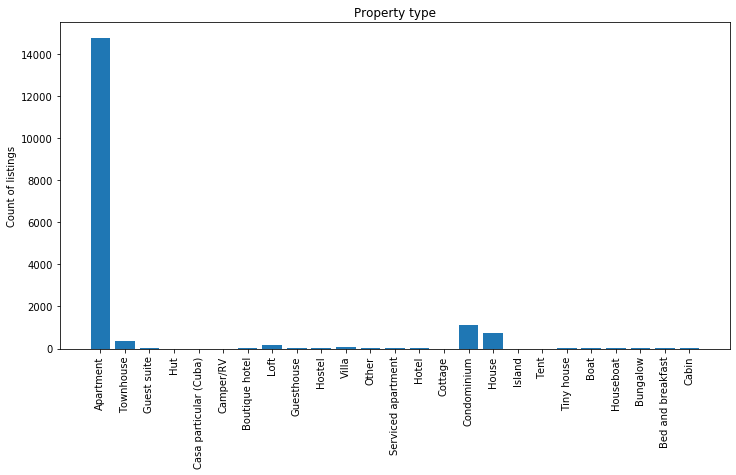

In [28]:
import matplotlib.pyplot as plt
import numpy as np

y_pos = np.arange(len(x))

plt.figure(figsize=(12, 6))
plt.bar(y_pos, y, align='center')
plt.xticks(y_pos, x,rotation=90)
plt.ylabel('Count of listings')
plt.title('Property type')


plt.show()

## Prices
Compute the minimum, maximum and average listing price in your city. 

In [29]:
dfListingsCopenhagen.select(f.min('price'), f.max('price'), f.avg('price')).show()

+----------+----------+----------------+
|min(price)|max(price)|      avg(price)|
+----------+----------+----------------+
|       0.0|   59999.0|804.069665765403|
+----------+----------+----------------+



Compute and visualize the distribution of listing prices in your city.

We just filter the data by our city, clean up the price strings to a format that converts to a float and look at the distribution of the price

In [32]:
df_pandas = dfListingsCopenhagen.select('price').toPandas()

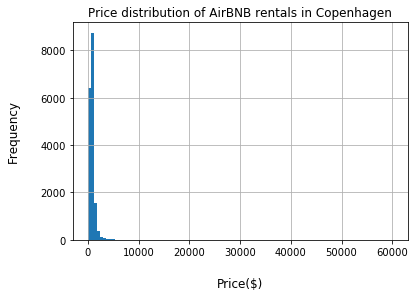

In [33]:
ax = df_pandas.hist(column='price',bins=100)
ax = ax[0]
for x in ax:
    x.set_title("Price distribution of AirBNB rentals in Copenhagen")
    x.set_xlabel("Price($)", labelpad=20, size=12)
    x.set_ylabel("Frequency", labelpad=20, size=12)

It can be seen that this distribution is very heavy-tailed having a maximum price of around 60000$. Let's try to cut of the 100 largest prices to focus in on the most dense part of the distribution.

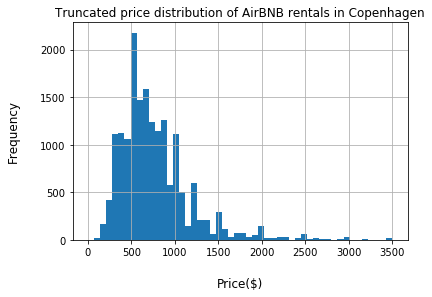

In [34]:
df_pandas_red = df_pandas
q = df_pandas['price'].nlargest(100)
for elements in q.keys():
    df_pandas_red = df_pandas_red.drop(elements)
ax = df_pandas_red.hist(column='price',bins=50)

ax = ax[0]
for x in ax:
    x.set_title("Truncated price distribution of AirBNB rentals in Copenhagen")
    x.set_xlabel("Price($)", labelpad=20, size=12)
    x.set_ylabel("Frequency", labelpad=20, size=12)

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

In [16]:
sort_by_price_window = Window.partitionBy('neighbourhood').orderBy(f.desc('price'))
ranked_df = dfListings.filter(f.col('city') == 'København').withColumn("price_Rank_neighbourhood",f.rank().over(sort_by_price_window))
ranked_df.filter(f.col("price_Rank_neighbourhood")<=3).orderBy("neighbourhood",f.desc("price")).select("neighbourhood","price","price_Rank_neighbourhood").show()

+--------------+-------+------------------------+
| neighbourhood|  price|price_Rank_neighbourhood|
+--------------+-------+------------------------+
|        Amager|34801.0|                       1|
|        Amager|16637.0|                       2|
|        Amager| 4003.0|                       3|
|   Amager Vest|10120.0|                       1|
|   Amager Vest| 5562.0|                       2|
|   Amager Vest| 4966.0|                       3|
|    Amager Øst| 9001.0|                       1|
|    Amager Øst| 3248.0|                       2|
|    Amager Øst| 3201.0|                       3|
|     Amagerbro| 2498.0|                       1|
|     Amagerbro| 2001.0|                       2|
|     Amagerbro| 1692.0|                       3|
|      Brønshøj| 5000.0|                       1|
|      Brønshøj| 3358.0|                       2|
|      Brønshøj| 2989.0|                       3|
|   Christiania|  751.0|                       1|
|Christianshavn| 2771.0|                       1|


## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

In [35]:
dfListingsCopenhagenWithReviews = dfReviews.selectExpr("listing_id","id as review_id", "comments", "date").join(dfListingsCopenhagen, dfReviews.listing_id == dfListingsCopenhagen.id)

In [36]:
a = dfListingsCopenhagenWithReviews.groupBy(f.year(f.col("date"))).agg(f.count("id")).take(100)

In [37]:
b = [i.asDict() for i in a]

In [38]:
for i in b:
    i["year(date)"] = int(i["year(date)"])

In [39]:
b = sorted(b, key=lambda x: x["year(date)"])

In [40]:
x_values = [i["year(date)"] for i in b]

In [41]:
y_values = [i["count(id)"] for i in b]

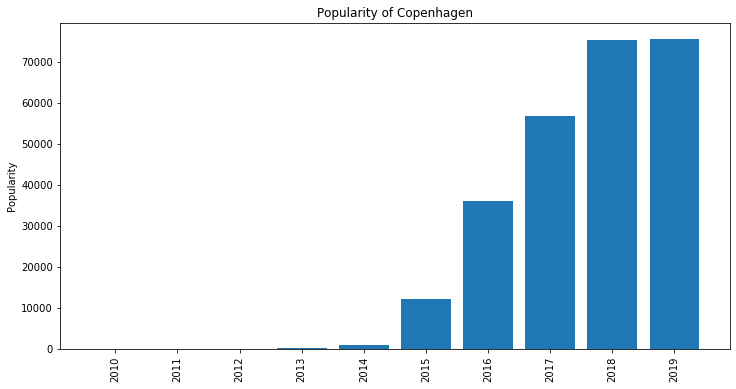

In [42]:
y_pos = np.arange(len(x_values))

plt.figure(figsize=(12, 6))
plt.bar(y_pos, y_values, align='center')
plt.xticks(y_pos, x_values,rotation=90)
plt.ylabel('Popularity')
plt.title('Popularity of Copenhagen')

plt.show()

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

In [43]:
df_join = dfListingsCopenhagen.join(dfReviews,dfListingsCopenhagen.id == dfReviews.listing_id).select('neighbourhood','date')

In [44]:
def ymd_to_ym(string):
    return datetime.datetime.strptime(string[0:7],'%Y-%m')
convert_date = udf(ymd_to_ym,DateType())

In [45]:
df_join = df_join.withColumn("date_mod",convert_date('date'))

In [46]:
df_join.select('neighbourhood','date_mod').groupBy('neighbourhood').agg(f.count('date_mod')).show()

+--------------+---------------+
| neighbourhood|count(date_mod)|
+--------------+---------------+
|      Indre By|          55165|
|    Teglholmen|            694|
|    Amager Øst|           7640|
|        Holmen|             46|
|       Kødbyen|            534|
|        Amager|          21984|
|         Valby|           9139|
|   Sluseholmen|            296|
|      Østerbro|          25525|
|     Amagerbro|           1746|
|      Brønshøj|           4302|
|      Nørrebro|          50415|
|  København NV|          10250|
|       Nyboder|            549|
| Frederiksberg|            377|
|     Vesterbro|          46712|
|Islands Brygge|           2659|
|   Christiania|              3|
|   Amager Vest|          10106|
|Christianshavn|           2941|
+--------------+---------------+
only showing top 20 rows



In [47]:
def pandas_neighbourhood_trend(neighbourhood):
    return df_join.filter(f.col('neighbourhood') == neighbourhood).groupBy('date_mod').agg(f.count('date_mod')).orderBy('date_mod',ascending=True).toPandas()

We take a look at some of the different neighbourhoods of Copenhagen. It is clear that the popularity of airbnb is increasing over time. Furthermore a (strong!) seasonal component can be seen. Do note that the above code could have used a filter claused using an OR(|) statement to get all the neighbourhoods in one go. 

In [48]:
pd_nørrebro = pandas_neighbourhood_trend('Nørrebro')
pd_vesterbro = pandas_neighbourhood_trend('Vesterbro')
pd_amagervest= pandas_neighbourhood_trend('Amager Vest')
pd_indreby = pandas_neighbourhood_trend('Indre By')

Text(0.5, 1.0, 'Amager Vest')

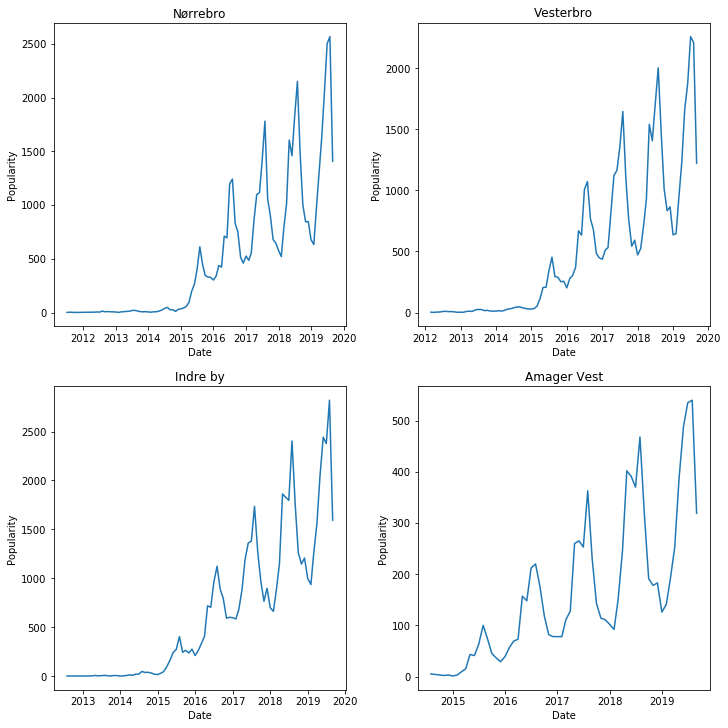

In [49]:
#pd_nørrebro = pandas_neighbourhood_trend('Nørrebro')
fig, axs = plt.subplots(2, 2, constrained_layout=True,figsize=(10,10))
axs[0,0].plot(pd_nørrebro['date_mod'],pd_nørrebro['count(date_mod)'])
axs[0,0].set_xlabel('Date')
axs[0,0].set_ylabel('Popularity')
axs[0,0].set_title('Nørrebro')

axs[0,1].plot(pd_vesterbro['date_mod'],pd_vesterbro['count(date_mod)'])
axs[0,1].set_xlabel('Date')
axs[0,1].set_ylabel('Popularity')
axs[0,1].set_title('Vesterbro')

axs[1,0].plot(pd_indreby['date_mod'],pd_indreby['count(date_mod)'])
axs[1,0].set_xlabel('Date')
axs[1,0].set_ylabel('Popularity')
axs[1,0].set_title('Indre by')

axs[1,1].plot(pd_amagervest['date_mod'],pd_amagervest['count(date_mod)'])
axs[1,1].set_xlabel('Date')
axs[1,1].set_ylabel('Popularity')
axs[1,1].set_title('Amager Vest')

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

In [17]:
def extract_month(date):
    return float(datetime.datetime.strptime(date[0:7],'%Y-%m').month)
extract_month_udf = udf(extract_month,FloatType())

In [18]:
df_list_rev = dfListings.join(dfReviews,dfListings.id == dfReviews.listing_id).select('city','date')
df_list_rev = df_list_rev.withColumn("month",extract_month_udf('date'))

In [19]:
import matplotlib.pyplot as plt
def monthly_trend_city(city,df):
    pd_city = df.filter(f.col('city') == city).groupBy('month').agg(f.count('month').alias("popularity")).toPandas()
    pd_city = pd_city.sort_values(by=['month'])
    plt.bar(pd_city['month'],pd_city['popularity'])
    plt.xlabel("month")
    plt.ylabel("popularity")
    plt.title(city)
    return pd_city

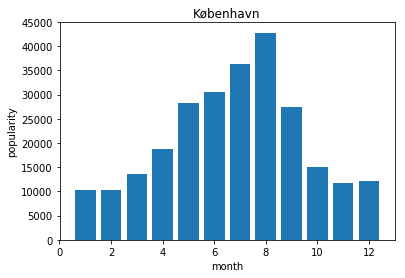

In [20]:
pd_city = monthly_trend_city("København",df_list_rev)

As seen from the above part we clearly see that there is a strong seasonal depencies. from above figure we see that there is high bokking of Airbnb during the 8th month i.e August in copenhagen

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

In order to find the popularity of words we only need two columns from the Listings dataframe. One is the id to join it with the Reviews dataframe and the review score of the listing.

In [73]:
dfListingReviewScores = dfListings.selectExpr("id as idOfListing", "review_scores_value")

During development we used a sample of the reviews dataframe.

In [67]:
dfReviewsSample = dfReviews.sample(True,0.03)

From the reviews dataframe we only need the id of the corresponding listing for the join and the text of the review.

In [68]:
dfReviewsSample = dfReviewsSample.select("listing_id", "comments")

We split the text of the review on spaces and create a list of words instead of one text.

In [69]:
dfReviewsSample = dfReviewsSample.withColumn("comments", f.split(f.col("comments"), " "))

With the explode function we create a new row for each words.

In [70]:
dfReviewsSample = dfReviewsSample.withColumn("word", f.explode("comments"))

From this point we only need the id of the listing and the word fields from the reviews dataframe.

In [71]:
dfReviewsSample = dfReviewsSample.select("listing_id","word")

Next we join the listings and reviews tables on the listing id column with an inner-join. We drop one of the duplicated listing id field.

In [75]:
dfWords = dfListingReviewScores.join(dfReviewsSample, dfReviewsSample.listing_id == dfListingReviewScores.idOfListing).drop("idOfListing")

We construct a function to make the words lowercase and remove punctuation marks from them.

In [76]:
import string

def convertWord(word):
    word = word.translate(str.maketrans('', '', string.punctuation))
    word = word.lower()
    return word

In [77]:
convertWord_udf = f.udf(convertWord)

We apply the function on the word column.

In [79]:
dfWords = dfWords.withColumn('word', convertWord_udf(f.col('word')))

In order to find a weight function for the words we group our dataframe by the word column and aggregate two columns, the average of the review score and the count of the occurances of the word.

In [81]:
dfWords = dfWords.groupBy("word").agg(f.avg("review_scores_value"), f.count("review_scores_value"))

We can now drop the rows where the count of the occurances of the word is too low. We decided to drop the rows where this count is < 100000

In [82]:
dfWords = dfWords.filter(f.col("count(review_scores_value)") > 10000)

We sort the dataframe based on the average review score in descending order.

In [84]:
dfWords = dfWords.sort(f.desc("avg(review_scores_value)"))

By calling show() on the dataframe we can see the top 20 rows.

In [85]:
dfWords.show()

+---------------+------------------------+--------------------------+
|           word|avg(review_scores_value)|count(review_scores_value)|
+---------------+------------------------+--------------------------+
|           home|       9.658807379583955|                     66291|
|recommendations|       9.647175959449674|                     11048|
|          their|       9.646753501126236|                     20422|
|           ever|       9.640525104424174|                     11731|
|      decorated|       9.636424731182796|                     11904|
|      welcoming|       9.630861723446893|                     22455|
|          hosts|       9.629367905630982|                     35944|
|           tips|       9.627964022894522|                     15899|
|      beautiful|       9.626666666666667|                     52500|
|      breakfast|       9.626160550748438|                     15833|
|        private|       9.623296820732033|                     14972|
|      wonderful|   